In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
import cv2
import torchvision
import sys


In [73]:
class FileReader:
    def __init__(self, csv_file_name):
        self._csv_file_name = csv_file_name
    def read(self):
        self._data = pd.read_csv(self._csv_file_name)


In [74]:
file_reader = FileReader('fer2013_noise_bi.csv')
file_reader.read()


In [75]:
columns = file_reader._data.columns.values
classes = sorted(file_reader._data['emotion'].unique())
distribution = file_reader._data.groupby('Usage')['emotion'].value_counts().to_dict()


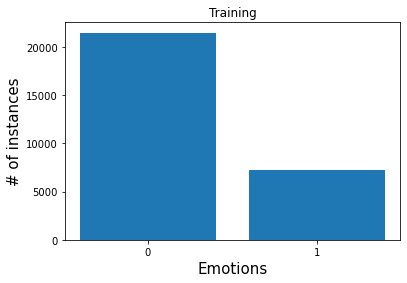

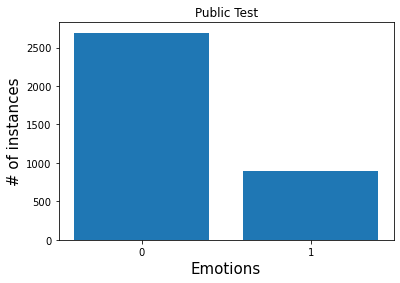

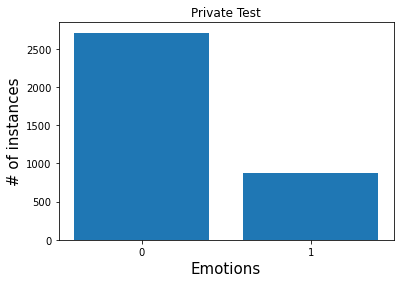

In [76]:
# Trainig Instances
plt.bar(classes, [distribution[('Training', i)] for i in classes])
plt.xlabel('Emotions', fontsize=15)
plt.ylabel('# of instances', fontsize=15)
plt.xticks(classes, classes, fontsize=10)
plt.title('Training')
plt.show()

# Development instances
plt.bar(classes, [distribution[('PublicTest', i)] for i in classes])
plt.xlabel('Emotions', fontsize=15)
plt.ylabel('# of instances', fontsize=15)
plt.xticks(classes, classes, fontsize=10)
plt.title('Public Test')
plt.show()

# Validation Instances

plt.bar(classes, [distribution[('PrivateTest', i)] for i in classes])
plt.xlabel('Emotions', fontsize=15)
plt.ylabel('# of instances', fontsize=15)
plt.xticks(classes, classes, fontsize=10)
plt.title('Private Test')
plt.show()


In [77]:
class Data:
    """
        Initialize the Data utility.
        :param data:
                    a pandas DataFrame containing data from the
                    FER2013 dataset.
        :type file_path:
                    DataFrame
        class variables:
        _x_train, _y_train:
                    Training data and corresopnding labels
        _x_test, _y_test:
                    Testing data and corresopnding labels
        _x_valid, _y_validation:
                    Validation/Development data and corresopnding labels

    """
    def __init__(self, data):
        self._x_train, self._y_train = [],  []
        self._x_test, self._y_test = [], []
        self._x_valid, self._y_valid = [], []

        for xdx, x in enumerate(data.values):
            pixels = []
            label = None
            for idx, i in enumerate(x[1].split(' ')):
                pixels.append(int(i))
            pixels = np.array(pixels).reshape((1, 48, 48))

            if x[2] == 'Training':
                self._x_train.append(pixels)
                self._y_train.append(int(x[0]))
            elif x[2] == 'PublicTest':
                self._x_test.append(pixels)
                self._y_test.append(int(x[0]))
            else:
                self._x_valid.append(pixels)
                self._y_valid.append(int(x[0]))
                
        self._x_train, self._y_train = np.array(self._x_train).reshape((len(self._x_train), 1, 48, 48)),\
            np.array(self._y_train, dtype=np.int64)
            
        self._x_test, self._y_test = np.array(self._x_test).reshape((len(self._x_test), 1, 48, 48)),\
            np.array(self._y_test, dtype=np.int64)
            
        self._x_valid, self._y_valid = np.array(self._x_valid).reshape((len(self._x_valid), 1, 48, 48)),\
            np.array(self._y_valid, dtype=np.int64)


In [78]:
data = Data(file_reader._data)


In [79]:
data._x_train = np.asarray(data._x_train, dtype=np.float64)
data._x_train -= np.mean(data._x_train, axis = 0)

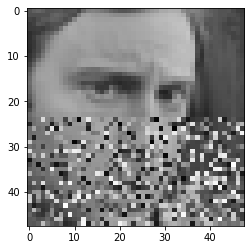

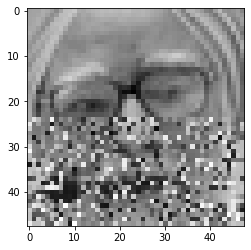

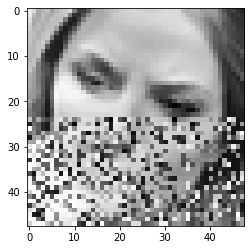

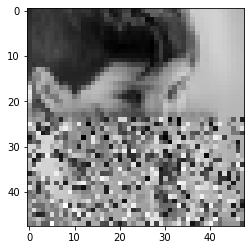

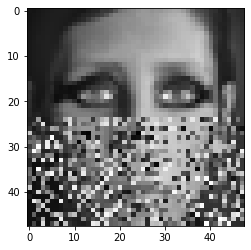

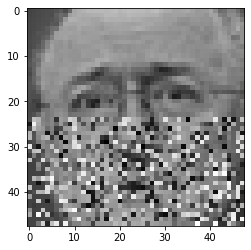

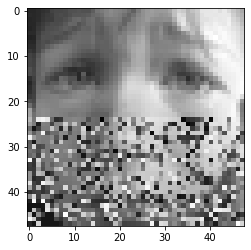

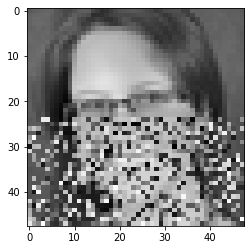

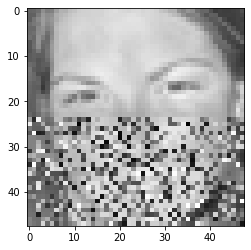

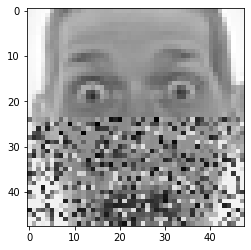

In [80]:
for ix in range(10):
    plt.figure(ix)
    plt.imshow(data._x_train[ix].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()


In [81]:
# class CNN(nn.Module):
#     def __init__(self, num_classes=7):
#         super(CNN, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=5),
#             nn.PReLU(),
#             nn.ZeroPad2d(2),
#             nn.MaxPool2d(kernel_size=5, stride=2)
#         )

#         self.layer2 = nn.Sequential(
#             nn.ZeroPad2d(padding=1),
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.PReLU(),
#             nn.ZeroPad2d(padding=1)
#         )

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3),
#             nn.PReLU(),
#             nn.AvgPool2d(kernel_size=3, stride=2)
#         )

#         self.layer4 = nn.Sequential(
#             nn.ZeroPad2d(1),
#             nn.Conv2d(128, 128, kernel_size=3),
#             nn.PReLU()
#         )

#         self.layer5 = nn.Sequential(
#             nn.ZeroPad2d(1),
#             nn.Conv2d(128, 128, kernel_size=3),
#             nn.PReLU(),
#             nn.ZeroPad2d(1),
#             nn.AvgPool2d(kernel_size=3, stride=2)
#         )

#         self.fc1 = nn.Linear(3200, 1024)
#         self.prelu = nn.PReLU()
#         self.dropout = nn.Dropout(p=0.2)
#         self.fc2 = nn.Linear(1024, 1024)
#         self.fc3 = nn.Linear(1024, 2)
#         self.log_softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, x):

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)

#         x = x.view(x.size(0), -1)

#         x = self.fc1(x)
#         x = self.prelu(x)
#         x = self.dropout(x)

#         x = self.fc2(x)
#         x = self.prelu(x)
#         x = self.dropout(x)

#         y = self.fc3(x)
#         y = self.log_softmax(y)
#         return y


# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Conv2d(1, 16, 5, padding=2),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, 5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
        
#         r"""input : 28*28 single channel image
#             28*28
#         -> nn.Conv2d(1, 16, 5)  : kernel=(5,5), stride=1, padding=0
#         -> 24*24 : (28-4)*(28-4)
#         -> nn.Conv2d(16, 32, 5) : kernel=(5,5), stride=1, padding=0
#         -> 20*20 : (24-4)*(24-4)
#         -> nn.MaxPool2d(2, 2)   : window=(2,2), stride=2
#         -> 10*10 : (20/2)*(20/2)
#         -> nn.Conv2d(32, 64, 5) : kernel=(5,5), stride=1, padding=0
#         -> 6*6   : (10-4)*(10-4)
#         -> nn.MaxPool2d(2, 2)   : window=(2,2), stride=2
#         -> 3*3   : (6/2)*(6/2)
#         """
#         self.fc_layer = nn.Sequential(
#             nn.Linear(64*(12*12), 100),
#             nn.ReLU(),
#             nn.Linear(100, 2),
#             nn.LogSoftmax(dim=1)
#         )
        
#     def forward(self, x):
#         out = self.layer(x)
#         out = out.view(out.size(0), -1)
#         out = self.fc_layer(out)
#         return out
    

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        r"""input : 28*28 single channel image
            28*28
        -> nn.Conv2d(1, 16, 5)  : kernel=(5,5), stride=1, padding=0
        -> 24*24 : (28-4)*(28-4)
        -> nn.Conv2d(16, 32, 5) : kernel=(5,5), stride=1, padding=0
        -> 20*20 : (24-4)*(24-4)
        -> nn.MaxPool2d(2, 2)   : window=(2,2), stride=2
        -> 10*10 : (20/2)*(20/2)
        -> nn.Conv2d(32, 64, 5) : kernel=(5,5), stride=1, padding=0
        -> 6*6   : (10-4)*(10-4)
        -> nn.MaxPool2d(2, 2)   : window=(2,2), stride=2
        -> 3*3   : (6/2)*(6/2)
        """
        self.fc_layer = nn.Sequential(
            nn.Linear(64*(12*12), 100),
            nn.ReLU(),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out

In [82]:
class FER2013Dataset(Dataset):
    """FER2013 Dataset."""

    def __init__(self, X, Y, transform=None):
        """
        Args:
            X (np array): Nx1x32x32.
            Y (np array): Nx1.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self._X = X
        self._y = Y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        if self.transform:
        #   return {'inputs': self.transform(self._X[idx]), 'labels': self._y[idx]}
        # return {'inputs': self._X[idx], 'labels': self._y[idx]}
              return self.transform(self._X[idx]), self._y[idx]
        return self._X[idx], self._y[idx]


In [83]:
NUM_EPOCHS = 100
BATCH_SIZE = 128
LR = 0.1
MIN_LR = 0.0000001
MODEL_PATH_PREFIX = 'model-cnn-epoch'
MODEL_PATH_EXT = 'pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [84]:
# preprocess = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(6),
#     transforms.ColorJitter()
# ])

# train_set = FER2013Dataset(data._x_train, data._y_train, transform=preprocess)
# test_set = FER2013Dataset(data._x_valid, data._y_valid)

# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

train_set = FER2013Dataset(data._x_train, data._y_train)
test_set = FER2013Dataset(data._x_valid, data._y_valid)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)


In [85]:


def train(model, dataset_loader, epoch, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i , (data, target) in enumerate(dataset_loader):
        inputs, labels = data, target
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        """
        print('Train: [Epoch: {}/{}, Batch: {} ({:.0f}%)]'
              .format(
                  epoch,
                  NUM_EPOCHS,
                  i + 1,
                  i*100/len(train_loader)
              ), end='\r')
        """
    return running_loss

def test(model, dataset_loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    valid_loss = 0

    with torch.no_grad():
        for i, (data, target) in enumerate(dataset_loader):

            images, labels = data, target
            images = images.float()
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            valid_loss += F.nll_loss(outputs, labels).item()

            pred = outputs.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

    accuracy = 100 * correct / len(test_loader.dataset)
    return valid_loss, accuracy

def load_model(best_model, learning_rate, device):
    checkpoint = torch.load(
        '{}-{}.{}'.format(
            MODEL_PATH_PREFIX,str(best_model), MODEL_PATH_EXT
        )
    )

    model = CNN()
    model.load_state_dict(checkpoint['model'])
    model.to(device)

    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, eps=1e-08)
    optimizer.load_state_dict(checkpoint['optimizer'])

    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)
    return model, optimizer

def restart_training(best_model, learning_rate, device):
    model, optimizer = load_model(best_model, learning_rate, device)

In [86]:
import torchvision.models as models

cnn = models.vgg16(pretrained=True)


# cnn = CNN()
cnn = cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(cnn.parameters(), lr=LR, rho=0.95, eps=1e-08)


In [87]:
loss_es = []
best_accuracy = 0.0
last_acc = 0
best_model = -1


In [88]:
count_acc = 0
epoch = 1
print("Epoch\tTrain Loss\tValidation Loss\tValidation Acc\tBest Model")
while epoch <= NUM_EPOCHS:
    running_loss = train(cnn, train_loader, epoch, device, optimizer, criterion)
    valid_loss, accuracy = test(cnn, test_loader, device, criterion)
    # record all the models that we have had so far.
    loss_es.append((running_loss, valid_loss, accuracy))
    # write model to disk.

    state = {
        'model': cnn.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    'models/model-cnn-epoch'
    torch.save(state, MODEL_PATH_PREFIX + '-{}.'.format(epoch) + MODEL_PATH_EXT)

    """
    SIMPLE MOMENTUM CONTROL.
    NOT NEEDED IN CASE OF ADADELTA.

    # reset if:
    #   1. the accuracy is less than the best accuracy so far
    #   2. the accuracy is equal to the best accuracy so far for preset # of counts.
    #   3. train accuracy is increasing but test accuracy is decreasing.
    if accuracy < best_accuracy or int(accuracy) == int(best_accuracy):
        count_acc += 1
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = epoch
        print('Best Accuracy: {}'.format(best_accuracy))
    if count_acc == 5:
        if LR/4 < MIN_LR:
            # END TRAINING.
            break
        else:
            LR/=4
        print(
            'Plateau identified: Restarting with the best model: {} and reduced learning rate: {}.'
            .format(best_model, LR)
        )
        cnn, optimizer = restart_training(best_model, LR, device)
        # transfer everything back to the cuda cores.

        count_acc = 0
        epoch = best_model
    """
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = epoch
    print('{}\t{:.5f}\t{:.5f}\t{:.3f}\t\t{}'.format(
        epoch,
        running_loss,
        valid_loss,
        accuracy,
        best_model
    ))
    epoch+=1

print('Trainig complete')


Epoch	Train Loss	Validation Loss	Validation Acc	Best Model
1	131.31216	20.09364	75.508		1
2	118.78048	15.74423	75.592		2
3	112.16057	16.36102	75.536		2
4	106.68889	23.78642	75.481		2
5	102.04030	19.80215	75.592		2
6	97.09001	15.87399	75.731		6
7	92.18388	16.76353	76.149		7
8	86.37271	26.66384	75.592		7
9	81.66408	22.31273	75.704		7
10	75.45784	17.90879	68.181		7
11	69.86906	24.91169	75.759		7
12	64.36065	23.59549	75.954		7
13	59.38728	22.84666	75.787		7
14	54.89842	18.16255	74.505		7
15	49.78982	21.76147	75.843		7
16	44.28839	20.62190	63.444		7
17	41.45732	30.42975	75.731		7
18	36.29916	25.04788	75.508		7
19	32.05536	32.62185	75.620		7
20	29.72232	23.90787	75.397		7
21	24.71675	32.43494	75.453		7
22	21.18643	28.33907	75.648		7
23	17.58518	35.36824	75.815		7
24	16.48805	32.76903	76.121		7
25	14.23787	24.06196	73.168		7
26	12.55646	37.80233	75.787		7
27	11.07313	35.63586	75.536		7
28	9.21973	45.84638	75.704		7
29	8.15962	41.35960	75.676		7
30	7.96785	35.33692	75.202		7
31	7.10517	39.4611

KeyboardInterrupt: 